## Setting up the environment
This [Jupyter Notebook](https://jupyterlab.readthedocs.io/en/latest/) was made to run on Google Colab. Please read [instructions on Google Colab](https://medium.com/swlh/the-best-place-to-get-started-with-ai-google-colab-tutorial-for-beginners-715e64bb603b) if you want more information regarding Google Colab.

Some notes on Google Colab:

- Processes in Google Colab won't run forever. These may be terminated at any time when the platform is crowded, and will definitely terminate after 12 hours. To maintain persistency, you can attach the session to Google Drive below so that the your notebook (and your modifications) are saved.
- You can enable GPU or TPU support! You can find this option under Runtime -> Change runtime type.
- After installing dependencies, you need to restart the runtime in order to actually use them.

### Installing the dependencies
Some dependencies need to be installed for the code to work.

In [ ]:
!pip install matplotlib > /dev/null
!pip install pandas > /dev/null
!pip install numpy > /dev/null
!pip install seaborn > /dev/null
!pip install geopandas > /dev/null

Next, all libraries containing helper functions are imported.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

from google.colab import drive

sns.set_theme(style="darkgrid")
%matplotlib inline

You need to have a shortcut in 'My Drive' to run this code

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/ML Workshop/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ML Workshop


# Evolutionary Algorithms

Evolutionary Algorithms are special methods to solve computational problems, such as optimization problems. They often yield very good results in a reasonable amount of time without us having to put a lot of thought into the problem-specific properties.

### Motivation
Evolutionary Algorithms are designed to resemble the evolution found in nature. Among other things, these three concepts are the core of evolution:  

1. There is a population of individuals.
2. Individuals can reproduce and die. Any of these things happening is determined by its fitness. The higher the fitness, the longer the individual’s properties (DNA) stay in the population, either by the individual itself or its offsprings.
3. Individuals can mutate, i.e. alter their properties a bit.

### Meta-algorithm
With these concepts we can create a meta-algorithm (an algorithm that internally uses other algorithms that have yet to be specified) to solve our problem:

1. Generate an initial population of individuals randomly.
2. Evaluate the fitness of each individual in the population.
3. Repeat as often as you like:  
    a). Select individuals with a good fitness score for reproduction.  
    b). Let them produce offsprings.  
    c). Mutate these offsprings.  
    d). Evaluate the fitness of each individual in the population.  
    f). Let the individuals with a bad fitness score die.
4. Pick the individual with the highest fitness as the solution.


## The Travelling Salesman Problem
The travelling salesman problem is described as follows:  

Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?

The Travelling Salesman Problem (TSP) is all about finding the shortest round trip through _n_ cities.

In [ ]:
class TSP:
    def __init__(self, value=None, init_params=None):
        if value is not None:
            self.value = value
        else:
            self.value = self._random_init(init_params)

    def pair(self, other, pair_params):
        self_head = self.value[:int(len(self.value) * pair_params['alpha'])].copy()
        self_tail = self.value[int(len(self.value) * pair_params['alpha']):].copy()
        other_tail = other.value[int(len(other.value) * pair_params['alpha']):].copy()

        mapping = {other_tail[i]: self_tail[i] for i in range(len(self_tail))}

        for i in range(len(self_head)):
            while self_head[i] in other_tail:
                self_head[i] = mapping[self_head[i]]

        return TSP(np.hstack([self_head, other_tail]))

    def mutate(self, mutate_params):
        for _ in range(mutate_params['rate']):
            i, j = np.random.choice(range(len(self.value)), 2, replace=False)
            self.value[i], self.value[j] = self.value[j], self.value[i]

    def _random_init(self, init_params):
        return np.random.choice(range(init_params['n_cities']), init_params['n_cities'], replace=False)

### Population class
This class holds the information about the population and the individuals in the population.

In [ ]:
class Population:
    def __init__(self, size, fitness, individual_class, init_params):
        self.fitness = fitness
        self.individuals = [individual_class(init_params=init_params) for _ in range(size)]
        self.individuals.sort(key=lambda x: self.fitness(x))

    def replace(self, new_individuals):
        """Remove x individuals from the population based on the fitness.
        x is decided by the amount of new individuals (new_individuals)."""
        size = len(self.individuals)
        self.individuals.extend(new_individuals)
        self.individuals.sort(key=lambda x: self.fitness(x))
        self.individuals = self.individuals[-size:]

    def get_parents(self, n_offsprings):
        """Select the mothers and fathers of the new offspring based on the amount of offspring needed."""
        mothers = self.individuals[-2 * n_offsprings::2]
        fathers = self.individuals[-2 * n_offsprings + 1::2]

        return mothers, fathers

### Evolution class
This class takes care of the evolutions.

In [ ]:
class Evolution:
    def __init__(self, pool_size, fitness, individual_class, n_offsprings, pair_params, mutate_params, init_params):
        self.pair_params = pair_params
        self.mutate_params = mutate_params
        self.pool = Population(pool_size, fitness, individual_class, init_params)
        self.n_offsprings = n_offsprings

    def step(self):
        mothers, fathers = self.pool.get_parents(self.n_offsprings)
        offsprings = []

        for mother, father in zip(mothers, fathers):
            offspring = mother.pair(father, self.pair_params)
            offspring.mutate(self.mutate_params)
            offsprings.append(offspring)

        self.pool.replace(offsprings)

In [ ]:
def tsp_fitness_creator(cities):
    matrix = []
    for city in cities:
        row = []
        for city_ in cities:
            row.append(111*np.linalg.norm(city - city_))
        matrix.append(row)
    distances = np.array(matrix)

    def fitness(tsp):
        res = 0
        for i in range(len(tsp.value)):
            res += distances[tsp.value[i], tsp.value[(i + 1) % len(tsp.value)]]
        return -res

    return fitness


def compute_distances(cities):
    distances = []
    for from_city in cities:
        row = []
        for to_city in cities:
            row.append(111*np.linalg.norm(from_city - to_city))
        distances.append(row)
    return np.array(distances)


def route_length(distances, route):
    length = 0
    for i in range(len(route)):
        length += distances[route[i], route[(i + 1) % len(route)]]
    return length

def plot_map (cities):

    spain = gpd.read_file('./Spain/')

    plt.figure(figsize=(12, 8))
    spain.plot(ax=plt.gca(), color='lightgray',zorder=0)
    plt.scatter(x=cities[:, 0], y=cities[:, 1], s=200, zorder=10)
    for i in range(len(cities)):
        plt.text(cities[i][0], cities[i][1], str(i), horizontalalignment='center', verticalalignment='center', size=8,
                  c='white',zorder=11)

    plt.xlabel('Longitude (º)')
    plt.ylabel('Latitude (º)')
    plt.xlim(left=-10)
    plt.xlim(right=4)
    plt.ylim(top = 44)
    plt.ylim(bottom = 36)
    plt.show()


def plot_route(cities, route, distances):

    spain = gpd.read_file('./Spain/')

    length = route_length(distances, route)

    plt.figure(figsize=(12, 8))
    spain.plot(ax=plt.gca(), color='lightgray',zorder=0)
    plt.scatter(x=cities[:, 0], y=cities[:, 1], s=200, zorder=10)
    for i in range(len(cities)):
        plt.text(cities[i][0], cities[i][1], str(i), horizontalalignment='center', verticalalignment='center', size=8,
                 c='white',zorder=11)
    for i in range(len(route)):
        plt.plot([cities[route[i]][0], cities[route[(i + 1) % len(route)]][0]],
                 [cities[route[i]][1], cities[route[(i + 1) % len(route)]][1]], 'k', zorder=5)
    if len(route)>0:
        plt.title(f'Visiting {len(route)} cities in {length:.2f} km', size=16)
    else:
        plt.title(f'{len(cities)} cities', size=16)

    plt.xlabel('Longitude (º)')
    plt.ylabel('Latitude (º)')
    plt.xlim(left=-10)
    plt.xlim(right=4)
    plt.ylim(top = 44)
    plt.ylim(bottom = 36)
    plt.show()
lst = []

Run the evolutionary step and plot the history of fitness and the best individual at the end.

### Solving TSP on the 100 most populated cities in Spain

Let's define the variables and objects that we going to use.

In [ ]:
database = pd.read_csv('es.csv', header = 0)
database.sort_values(by='population_proper', ascending=False)
database.drop(database[database['admin_name'] == 'Balearic Islands'].index, inplace = True)
database.drop(database[database['admin_name'] == 'Canary Islands'].index, inplace = True)
database.drop(database[database['admin_name'] == 'Ceuta'].index, inplace = True)
database.drop(database[database['admin_name'] == 'Melilla'].index, inplace = True)
database.reset_index(drop=True, inplace=True)
sample = database[:100]
sample

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Madrid,40.4169,-3.7033,Spain,ES,Madrid,primary,6211000,3266126
1,Barcelona,41.3825,2.1769,Spain,ES,Catalonia,admin,4800000,1620343
2,Sevilla,37.2400,-5.9900,Spain,ES,Andalusia,admin,1100000,681998
3,Málaga,36.7194,-4.4200,Spain,ES,Andalusia,minor,967250,579076
4,Valencia,39.4700,-0.3764,Spain,ES,Valencia,admin,792492,792492
...,...,...,...,...,...,...,...,...,...
95,Mairena del Aljarafe,37.3333,-6.0667,Spain,ES,Andalusia,NaN,47161,47161
96,Figueras,42.2667,2.9650,Spain,ES,Catalonia,NaN,47088,47088
97,Gavá,41.3072,2.0039,Spain,ES,Catalonia,NaN,46974,46974
98,Esplugas de Llobregat,41.3767,2.0858,Spain,ES,Catalonia,NaN,46777,46414


In [ ]:
cities = np.array([[sample['lng'][i],sample['lat'][i]] for i in range (len(sample))])
#print (cities)

fitness = tsp_fitness_creator(cities)
distances = compute_distances(cities)

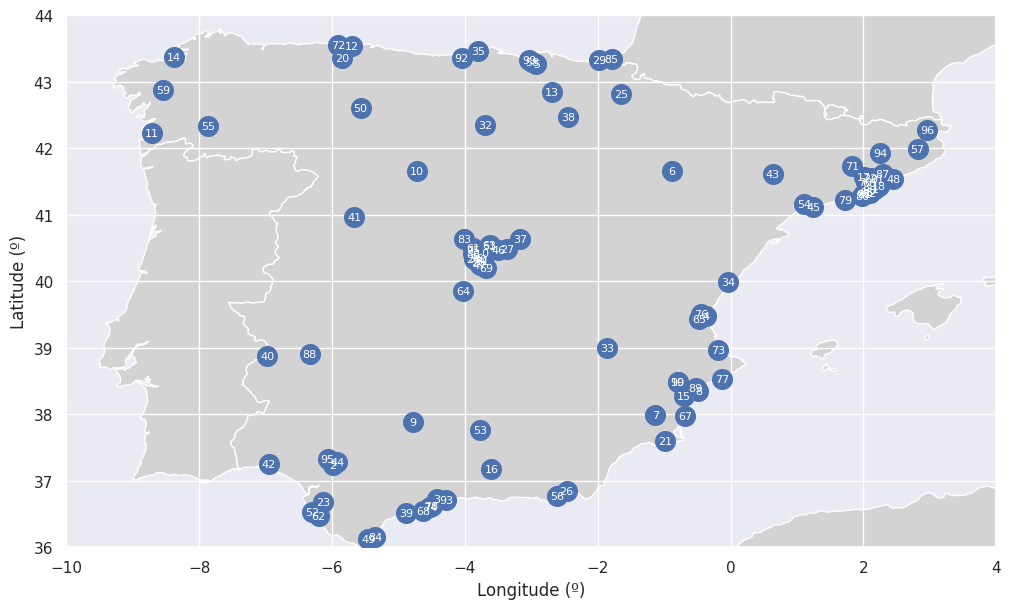

In [ ]:
plot_map (cities)

Lets also define the parameters for evolutionary step as showen below:


In [ ]:
# parameters for evolutionary step
pool = 100               # The amount of starting individuals
n_epochs = 30000          # How many round to run before exiting
n_cities = len(cities)   # The amount of cities
alpha = 0.8              # Decides where to split the individuals
n_offsprings = 30        # How many offsprings to create / and people to delete
mutation_rate = 1        # the amount of mutations each step

Now all set up, lets create and start our evoluation

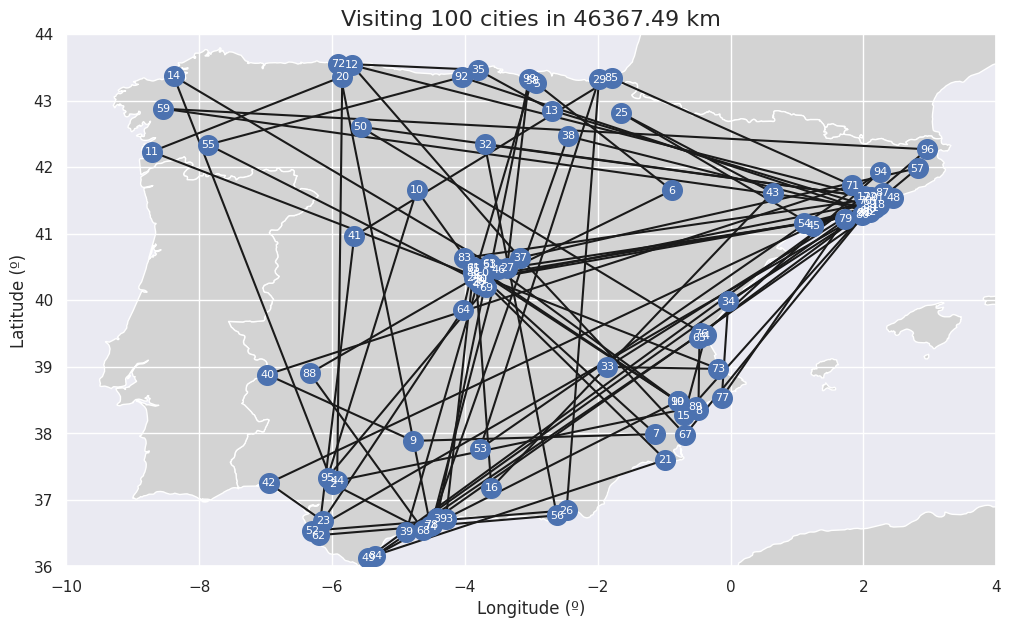

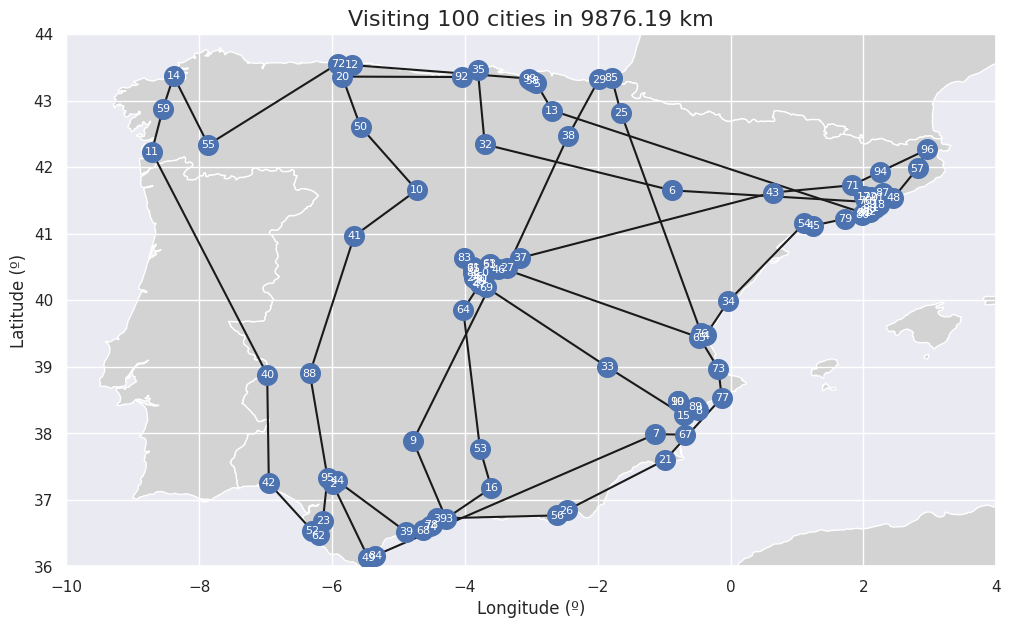

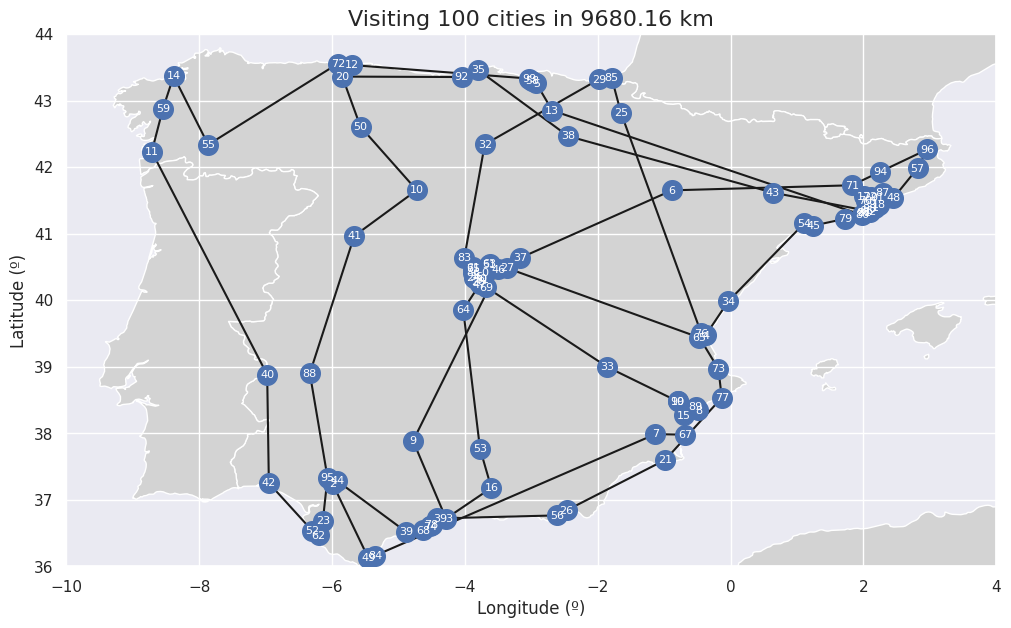

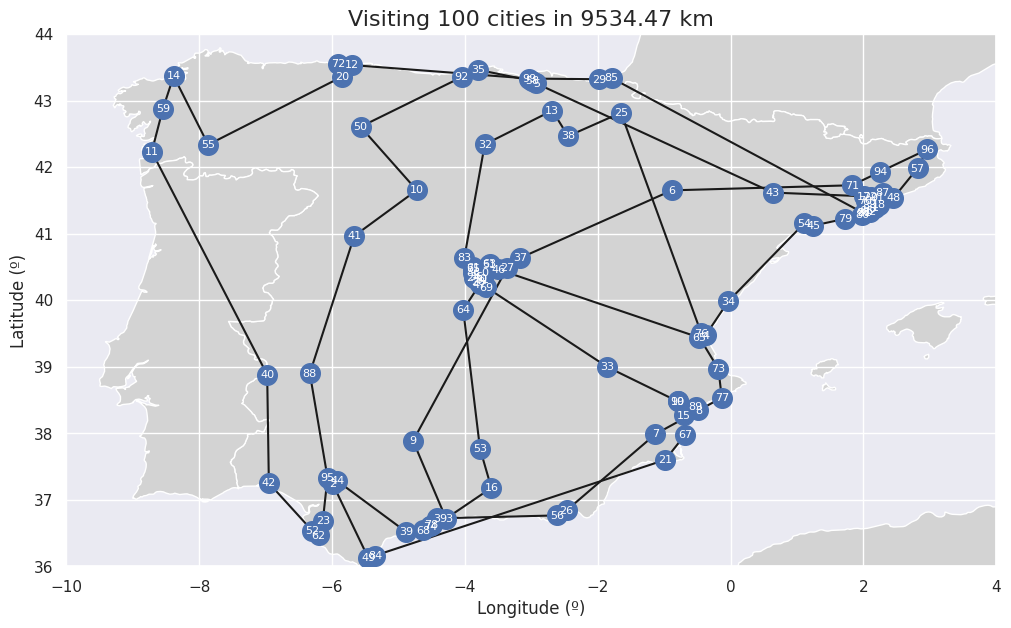

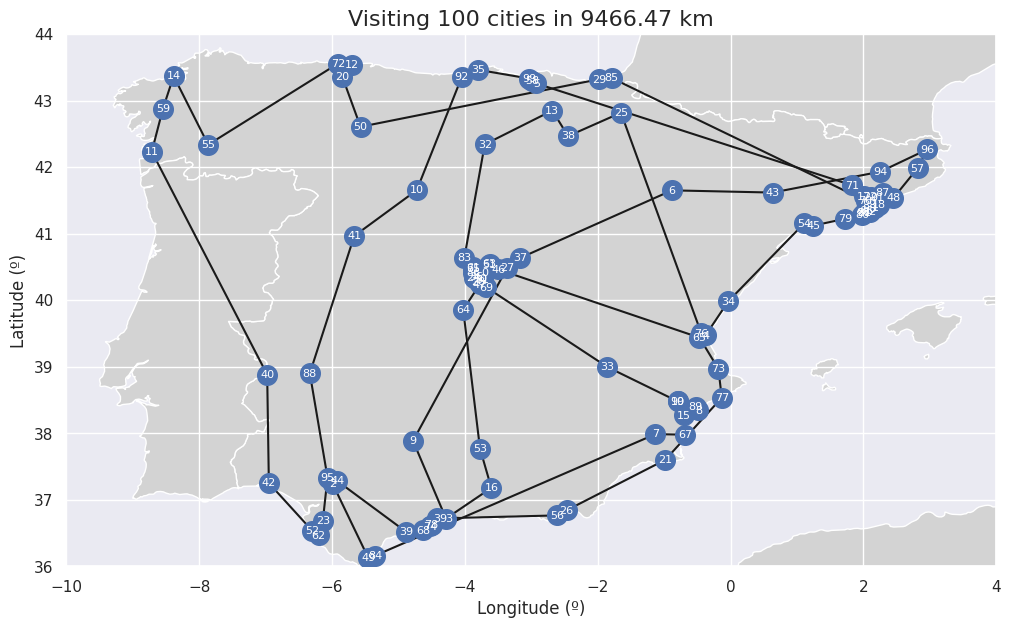

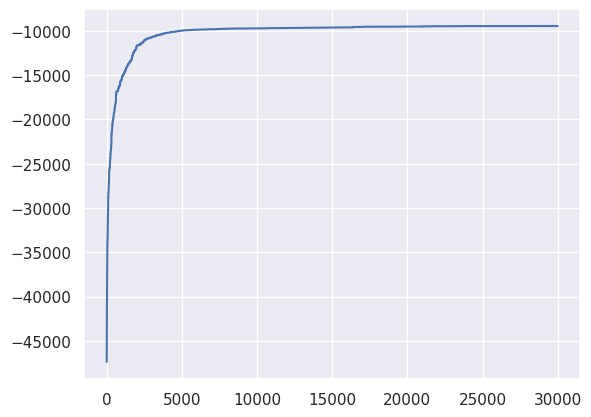

In [ ]:
evo = Evolution(
    pool_size=pool, fitness=fitness, individual_class=TSP,
    n_offsprings=n_offsprings,
    pair_params={'alpha': alpha},
    mutate_params={'rate': mutation_rate},
    init_params={'n_cities': n_cities}
)

# Save the results of every step to plot later
hist = []
for i in range(n_epochs):
    hist.append(evo.pool.fitness(evo.pool.individuals[-1]))
    evo.step()
    if i%(n_epochs/5) == 0:
      print ('Epoch = ', epoch)
      route = evo.pool.individuals[-1].value
      distances = distances
      plot_route(cities, route=route, distances=distances)

route = evo.pool.individuals[-1].value
distances = distances
lst.append([n_cities, n_epochs, alpha, mutation_rate, route_length(distances, route),])

plt.plot(hist)
plt.show()

Time to check the final results in a line plot and check the found route in the next chart.

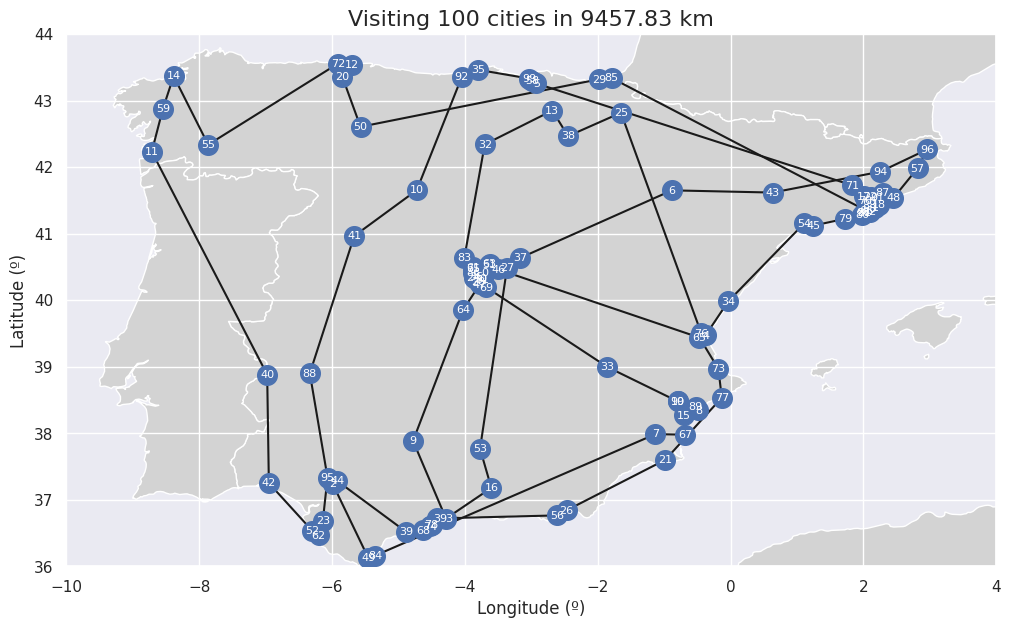

In [ ]:
plot_route(cities, route=route, distances=distances)